In [ ]:


import torch

from torch.utils.data import Dataset, DataLoader



from torchvision import transforms as T, utils

import matplotlib.pyplot as plt
from PIL import Image




from denoising_diffusion_pytorch.version import __version__

#ab diffusion related imports
from user_hints import *
from color_handling import de_normalize, normalize_lab, LAB2RGB
from IPython.utils import io as iol
from skimage import io
from kornia.color import rgb_to_lab, lab_to_rgb
from datasets import load_from_disk
from ab_trainer import *
#from ab_classifier_free_guidance import *

from ab_denoising_diffusion_pytorch import *

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import random
import glob
import mplcursors
import ipywidgets as widgets
from IPython.display import display
import torchvision.transforms as transforms
from datasets import load_dataset


In [ ]:


class ImageSampler:
    def __init__(self, image, model, sampling_size=2, device="cpu"):
        self.image = image.copy()
        self.device = device
        self.input_image_displayed = image.copy()
        self.output_image_displayed = image.copy()
        self.input_LAB_tensor = normalize_lab(rgb_to_lab(transforms.ToTensor()(self.input_image_displayed)).unsqueeze(0))
        self.output_LAB_tensor = normalize_lab(rgb_to_lab(transforms.ToTensor()(self.output_image_displayed)).unsqueeze(0))
        self.model = model
        self.sampling_size = sampling_size
        self.selected_color = (0, 0, 0)  # Default color is black
        
        self.fig, (self.input_ax, self.output_ax) = plt.subplots(1, 2, figsize=(10, 5))
        
        self.output = widgets.Output()
        self.slider = widgets.IntSlider(value=self.sampling_size, min=1, max=10, description='Sampling Size:')
        self.color_picker = widgets.ColorPicker(value=self.rgb_to_hex(self.selected_color), description='Color:')
        self.colorize_button = widgets.Button(description='Colorize!')
        self.clear_button = widgets.Button(description='Clear')
        self.colorize_button.on_click(self.colorize)
        self.clear_button.on_click(self.clear_inputs)
        
    def display(self):
        self.input_ax.set_title('Grayscale Image')
        self.output_ax.set_title('Output Image')

        self.fig.canvas.mpl_connect('button_press_event', self.on_image_click)
        self.output_ax.set_axis_off()
        self.slider.observe(self.on_slider_change, names='value')
        self.color_picker.observe(self.on_color_pick, names='value')
        
        vbox = widgets.VBox([self.fig.canvas, self.slider, self.color_picker, self.colorize_button, self.clear_button])
        display(vbox)
        self.draw_images()
        
    def on_slider_change(self, change):
        self.sampling_size = change.new
        
    def on_color_pick(self, change):
        color_hex = change.new
        self.selected_color = self.hex_to_rgb(color_hex)
        
    def displayed_img_to_data(self):
        self.input_LAB_tensor = normalize_lab(rgb_to_lab(transforms.ToTensor()(self.input_image_displayed).unsqueeze(0))).to(self.device)
        self.output_LAB_tensor = normalize_lab(rgb_to_lab(transforms.ToTensor()(self.output_image_displayed).unsqueeze(0))).to(self.device)
        
    def data_to_displayed_img(self):
        self.input_image_displayed = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize(self.input_LAB_tensor).squeeze(0).detach().cpu()
            )
        )
        self.output_image_displayed = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize(self.output_LAB_tensor).squeeze(0).detach().cpu()
            )
        )
        
    def draw_images(self):
        self.data_to_displayed_img()
        self.displayed_img_to_data()
        self.input_ax.imshow(self.input_image_displayed)
        self.fig.canvas.draw_idle()
        self.output_ax.imshow(self.output_image_displayed)
        self.fig.canvas.draw_idle()
        
    def on_image_click(self, event):
        if event.button == 1:  # Left mouse button clicked
            x = int(event.xdata)
            y = int(event.ydata)

            half_sampling = self.sampling_size // 2
            x_start = max(0, x - half_sampling)
            y_start = max(0, y - half_sampling)
            x_end = min(self.input_image_displayed.width, x + half_sampling)
            y_end = min(self.input_image_displayed.height, y + half_sampling)

            temp_rgb = self.input_image_displayed.copy()
            for i in range(x_start, x_end):
                for j in range(y_start, y_end):
                    temp_rgb.putpixel((i, j), self.selected_color)
            #
            input_AB = normalize_lab(self.convert_to_lab_tensor(temp_rgb))[:, 1:, :, :]
            #set all values in intput_AB that are not in the selected area to 0
            self.input_LAB_tensor[:, 1:, :, :] = input_AB
            self.draw_images()
                
    def colorize(self, _):
        output_AB = self.model.sample(self.input_LAB_tensor)
        self.output_LAB_tensor[:, 1:, :, :] = output_AB
        self.draw_images()
        
    def convert_to_lab_tensor(self, image):
        return rgb_to_lab(transforms.ToTensor()(image).unsqueeze(0))
    
    def clear_inputs(self, _):
        self.input_image_displayed = self.image.copy()
        self.input_LAB_tensor = normalize_lab(rgb_to_lab(transforms.ToTensor()(self.input_image_displayed)).unsqueeze(0))
        self.draw_images()
        
    @staticmethod
    def rgb_to_hex(color_rgb):
        return '#%02x%02x%02x' % color_rgb
    
    @staticmethod
    def hex_to_rgb(color_hex):
        color_hex = color_hex.lstrip('#')
        return tuple(int(color_hex[i:i+2], 16) for i in (0, 2, 4))


In [ ]:
test_folder = "data/tinyimgnet/val"
results_folder = "./results"

device = torch.device(7 if torch.cuda.is_available() else "cpu")
print("Selected GPU:", torch.cuda.get_device_name(device))
#check wicj gpu is selected
torch.cuda.set_device(device)

In [ ]:
dataset_test = load_dataset("imagenet-1k",split="validation")
dataset = ABDataset(dataset_test,image_size=256)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, pin_memory = True,num_workers=cpu_count()//6)



In [42]:
time_step = 30
num_timesteps = 100
print(range(time_step, num_timesteps))
print(range(0,num_timesteps))

range(30, 100)
range(0, 100)


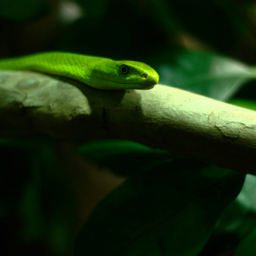

In [43]:
imgL, imgAB = next(iter(dataloader))
imgLAB = torch.cat((imgL,imgAB),dim=1)
imgRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize(imgLAB).squeeze(0).detach().cpu()
            )
        )

imgRGB.show()

In [ ]:
unet = ABUnet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    out_dim = 2,
    channels=5
    )

def load(milestone):
    print(str(results_folder  + f'/model-{milestone}.pt'))
    data = torch.load(str(results_folder  + f'/model-{milestone}.pt'), map_location=device)
    return data

diffusion_model = ABGaussianDiffusion(
        unet,
        image_size = 256,
        timesteps = 1000,
        objective = 'pred_v',
        beta_schedule = 'cosine',
        min_snr_loss_weight = False,
)

loaded_data = load(8)
diffusion_model.load_state_dict(loaded_data['model'])
diffusion_model.to(device)




In [ ]:


output_AB = diffusion_model.sample()

sampling timesteps 1000
timesteps 1000
./results/model-8.pt


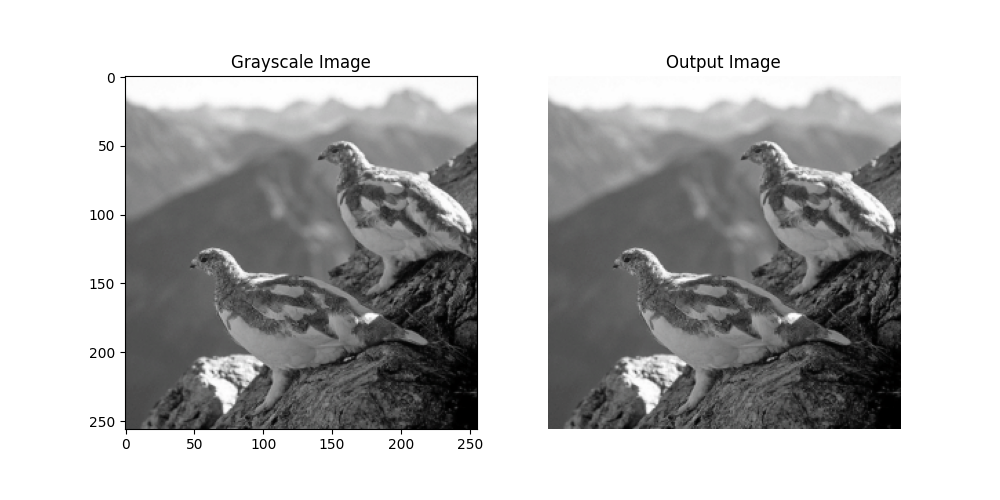

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [38]:
%matplotlib widget





#test the class by loading an image and creating a blank image
#test_folder = "data/sem-images 64/val"
#test_image = Image.open(test_folder + "/semcolorizedpollen9.png").convert('L').convert('RGB')
test_image = imgRGB.convert('L').convert('RGB')
img_samp = ImageSampler(test_image, diffusion_model, sampling_size=2,device=device)
img_samp.display()

In [ ]:
test_folder = "data/tinyimgnet/val"
results_folder = "./results"



def load(milestone):
    print(str(results_folder  + f'/model-{milestone}.pt'))
    data = torch.load(str(results_folder  + f'/model-{milestone}.pt'), map_location=device)
    return data
    


In [ ]:
model = ABUnet(
    dim = 64,
    out_dim = 2,
    channels=5,    

).to(device)
diffusion = ABGaussianDiffusion(
    model,
        image_size = 256,
        timesteps = 1000,
        objective = 'pred_v',
        beta_schedule = 'cosine',
        auto_normalize=False
).to(device)

hint_generator = RandomHintGenerator(
    input_size = 256,
    hint_size = 2,
    num_hint_range = [0, 10]
    
)

In [ ]:

def sample(model, dataloader = None, num_samples = 5,batch_size = 5,hint_generator = None,cond_scale = 1.0):
    images_pred_list = []
    images_hint_list = []
    images_original_list = []  

    batches = num_to_groups(num_samples, batch_size)
    
    
    for i, b in enumerate(batches):
        # one iteration of the dataloader
        imgL, imgAB = next(iter(dataloader))

        
        imgL_batch = imgL[:b].to(device)
        imgAB_batch = imgAB[:b].to(device)
        imgAB = imgAB.to(device)
        if hint_generator is not None:
            hints_sample = hint_generator(imgL.shape[0])
            hints_AB_sample = get_color_hints(imgAB,hints_sample,True,device)[:b].to(device)
            conditioning = torch.cat([imgL_batch, hints_AB_sample[:b]], dim=1).to(device)
        
        
        images_pred_list.append(torch.cat([imgL_batch, model.sample(conditioning)], dim=1))
        images_hint_list.append(conditioning)
        images_original_list.append(torch.cat([imgL_batch, imgAB_batch], dim=1))
        
        if hint_generator is not None:
            images_hint_list_rgb = [torch.from_numpy(LAB2RGB(im.cpu())).permute(0,3,1,2).to(device) for im in images_hint_list]
            images_hint_rgb= torch.cat(images_hint_list_rgb, dim = 0)
            images_hint_grid = utils.make_grid(images_hint_rgb, nrow=int(math.sqrt(num_samples))).permute(1,2,0)
        
        
        images_pred_list_rgb = [torch.from_numpy(LAB2RGB(im.cpu())).permute(0,3,1,2).to(device) for im in images_pred_list]
        images_pred_rgb= torch.cat(images_pred_list_rgb, dim = 0)
        images_original_list_rgb = [torch.from_numpy(LAB2RGB(im.cpu())).permute(0,3,1,2).to(device) for im in images_original_list]
        images_original_rgb= torch.cat(images_original_list_rgb, dim = 0)
        
        images_original_grid = utils.make_grid(images_original_rgb, nrow=int(math.sqrt(num_samples))).permute(1,2,0)
        images_pred_grid = utils.make_grid(images_pred_rgb, nrow=int(math.sqrt(num_samples))).permute(1,2,0)

        #convert to numpy arrays    
        images_pred_grid = images_pred_grid.cpu().detach().numpy()
        images_original_grid = images_original_grid.cpu().detach().numpy()
        images_hint_grid = images_hint_grid.cpu().detach().numpy()
        #display the grid images
        plt.figure(figsize=(10,10))
        plt.imshow(images_pred_grid)
        plt.show()
        plt.figure(figsize=(10,10))
        plt.imshow(images_original_grid)
        plt.show()
        plt.figure(figsize=(10,10))
        plt.imshow(images_hint_grid)
        plt.show()

In [ ]:



loaded_data = load(8)
diffusion.load_state_dict(loaded_data['model'])
diffusion = diffusion.to(device)

dataset_test = load_dataset("imagenet-1k",split="validation")
dataset = ABDataset(dataset_test,image_size=256)
dataloader = DataLoader(dataset, batch_size = 25, shuffle = True, pin_memory = True,num_workers=cpu_count()//6)

In [ ]:
#go one step trough the dataloader and sample
sample(diffusion,dataloader = dataloader, num_samples = 25,batch_size = 25,hint_generator = hint_generator)